# Classificação de empréstimo padrão

Este material mostra meu trabalho de construção de um modelo de classificação binária de linha de base usando Random Forest para prever se haverá um default no empréstimo (status de 'B' ou 'D').
site: https://www.kaggle.com/python10pm/sklearn-50-best-tips-and-tricks 

### Tabela de conteúdo

1. [Conectar ao banco de dados MySQL]
2. Análise Exploratória de Dados
3. [Extração de recurso]
4. [Correlação]
5. [Transformação]
6. [Modelagem]
7. [Importância do recurso]
8. [Direções futuras]


In [51]:
# Importando as Bibliotecas necessárias

In [1]:
import mysql.connector
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

<a name='mysql'></a>
## 1. Conectando com Database MySQL 

In [2]:
class MysqlIO:
    """Connect to MySQL server with python and excecute SQL commands."""
    def __init__(self, database='db_banco'):
        try:
            # Alterar o host, usuário e senha conforme necessário
            connection = mysql.connector.connect(host='localhost',
                                                 database=database,
                                                 user='root',
                                                 password='admjairo63',
                                                 use_pure=True
                                                 )
            if connection.is_connected():
                db_info = connection.get_server_info()
                print("Connected to MySQL Server version", db_info)
                print("Your're connected to database:", database)
                self.connection = connection
        except Exception as e:
            print("Error while connecting to MySQL", e)
            
    def execute(self, query, header=False):
        """Execute SQL commands and return retrieved queries."""
        cursor = self.connection.cursor(buffered=True)
        cursor.execute(query)
        try:
            record = cursor.fetchall()
            if header:
                header = [i[0] for i in cursor.description]
                return {'header': header, 'record': record}
            else:    
                return record
        except:
            pass
        
    def to_df(self, query):
        """Return the retrieved SQL queries into pandas dataframe."""
        res = self.execute(query, header=True)
        df = pd.DataFrame(res['record'])
        df.columns = res['header']
        return df

In [3]:
db = MysqlIO('db_banco')

Connected to MySQL Server version 8.0.22
Your're connected to database: db_banco


## 3. Extraindo  dados


O EDA é feito no notebook 'EDA.ipynb', então de acordo com os dados, vou pegar alguns desses dados e colocá-los em um dataframe e preparar para o ML

### Valor empréstimo, conta, cidade

In [4]:
query = """
    select id_conta, tb_emprestimo.date date_emprestimo, montante, duracao, pagamentos, status, frequencia, tb_conta.date date_acc,
        A4, A11, A12, A13, A14, A15, A16
    from tb_emprestimo join tb_conta using(id_conta)
    join tb_distrito using(id_cidade)"""
df = db.to_df(query)

In [5]:
#Verificando o tipo de dado de cada coluna
df.head() 

,id_conta,date_emprestimo,montante,duracao,pagamentos,status,frequencia,date_acc,A4,A11,A12,A13,A14,A15,A16
0,1787,1993-07-05,96396,12,8033.00,B,PAGAMENTO DIARIO,1993-03-22,94812,9650,3.38,3.67,100,2985,2804
1,1801,1993-07-11,165960,36,4610.00,A,PAGAMENTO MENSAL,1993-02-13,112709,8369,1.79,2.31,117,2854,2618
2,9188,1993-07-28,127080,60,2118.00,A,PAGAMENTO MENSAL,1993-02-08,77917,8390,2.28,2.89,132,2080,2122
3,1843,1993-08-03,105804,36,2939.00,A,PAGAMENTO MENSAL,1993-01-30,107870,8754,3.83,4.31,137,3804,3868
4,11013,1993-09-06,274740,60,4579.00,A,PAGAMENTO DIARIO,1993-02-14,1204953,12541,0.29,0.43,167,85677,99107


In [6]:
df.set_index('id_conta', inplace=True)

In [7]:
df['date_emprestimo'] = pd.to_datetime(df.date_emprestimo, format='%Y-%m-%d')
df['date_acc'] = pd.to_datetime(df.date_acc, format='%Y-%m-%d')
df['dias_emprestimo'] = (df['date_emprestimo'] - df['date_acc']).dt.days # Dias entre a criação da conta e a emissão do empréstimo
df['n_habitantes'] = df.A4
df['media_salarial'] = df.A11
df['taxa_media_desemprego'] = df[['A12', 'A13']].mean(axis=1)
df['taxa_empreendedor'] = df['A14']
df['taxa_media_crime'] = df[['A15', 'A16']].mean(axis=1) / df['n_habitantes']
df['default'] = (df['status'] == 'B') | (df['status'] == 'D')

In [8]:
df.head()

,date_emprestimo,montante,duracao,pagamentos,status,frequencia,date_acc,A4,A11,A12,...,A14,A15,A16,dias_emprestimo,n_habitantes,media_salarial,taxa_media_desemprego,taxa_empreendedor,taxa_media_crime,default
id_conta,,,,,,,,,,,,,,,,,,,,,
1787,1993-07-05,96396,12,8033.00,B,PAGAMENTO DIARIO,1993-03-22,94812,9650,3.38,...,100,2985,2804,105,94812,9650,3.525,100,0.030529,True
1801,1993-07-11,165960,36,4610.00,A,PAGAMENTO MENSAL,1993-02-13,112709,8369,1.79,...,117,2854,2618,148,112709,8369,2.050,117,0.024275,False
9188,1993-07-28,127080,60,2118.00,A,PAGAMENTO MENSAL,1993-02-08,77917,8390,2.28,...,132,2080,2122,170,77917,8390,2.585,132,0.026965,False
1843,1993-08-03,105804,36,2939.00,A,PAGAMENTO MENSAL,1993-01-30,107870,8754,3.83,...,137,3804,3868,185,107870,8754,4.070,137,0.035561,False
11013,1993-09-06,274740,60,4579.00,A,PAGAMENTO DIARIO,1993-02-14,1204953,12541,0.29,...,167,85677,99107,204,1204953,12541,0.360,167,0.076677,False


### Da ordem

In [9]:
query = """
    select id_conta, montante ordem_montante
    from `tb_ordem`
    where id_conta in (
        select id_conta
        from tb_emprestimo);
    """
df_order = db.to_df(query)

In [10]:
df_order.head()

,id_conta,ordem_montante
0,2,3372.70
1,2,7266.00
2,19,2523.20
3,25,2523.20
4,25,6817.00


In [11]:
#Verificando o tipo de dado de cada coluna
#df_order.dtypes 

In [12]:
df_order['ordem_montante'] = df_order.ordem_montante.astype('float')
df = df.join(df_order.groupby('id_conta').mean())
df = df.rename(columns={'ordem_montante': 'valor_medio_montante'})

### Da Transação

In [13]:
query = """
    select id_conta, montante montante_trans, balanco balanco_trans
    from tb_transacao
    where id_conta in (
        select id_conta
        from tb_emprestimo);
    """
df_trans = db.to_df(query)

In [14]:
#df_trans.head()

In [15]:
n_trans = df_trans.groupby('id_conta').count().iloc[:, 1]
n_trans.name = 'n_trans'

In [16]:
df_trans = df_trans.groupby('id_conta').mean()
df_trans.columns = ['quant_media_trans', 'saldo_medio_trans']

In [17]:
df = df.join(df_trans).join(n_trans)

### Do Cartão

In [18]:
query = """
    select id_conta, tb_cartao.tipo as tipo_cartao
    from tb_emprestimo join tb_disponivel using(id_conta)
    left join tb_cartao using(id_disp)
    where tb_disponivel.tipo = 'OWNER';
    """
df_card = db.to_df(query)

In [19]:
df = df.join(df_card.set_index('id_conta'), how='left')
df['tipo_cartao'].fillna('No', inplace=True)

### Proprietario da Conta

In [20]:
query = """
    select id_conta, tb_emprestimo.date data_emprestimo, tb_conta.id_cidade acc_id_cida, 
    tb_cliente.id_cidade cli_id_cida, sexo sexo_dono, dt_nascimento
    from tb_emprestimo join tb_conta using(id_conta)
    join tb_disponivel using(id_conta)
    join tb_cliente using(id_cliente)
    where tb_disponivel.tipo = 'OWNER';
    """
df_cli = db.to_df(query)

In [21]:
df_cli['mesma_cidade'] = df_cli['acc_id_cida'] == df_cli['cli_id_cida']
df_cli['date'] = pd.to_datetime(df_cli['data_emprestimo'], format='%Y-%m-%d')
df_cli['dt_nascimento'] = pd.to_datetime(df_cli['dt_nascimento'], format='%Y-%m-%d')
df_cli['idade_dono_conta'] = (df_cli['date'] - df_cli['dt_nascimento']).dt.days // 365

In [22]:
df = df.join(df_cli.set_index('id_conta')[['mesma_cidade', 'sexo_dono', 'idade_dono_conta']])

### A lista final de resultados

In [23]:
df_ml = df[['montante', 'duracao', 'pagamentos', 'dias_emprestimo', 'n_habitantes', 
            'media_salarial', 'taxa_media_desemprego', 'taxa_empreendedor', 
            'taxa_media_crime', 'valor_medio_montante', 'quant_media_trans', 
            'saldo_medio_trans', 'n_trans', 'idade_dono_conta', 
            'frequencia', 'tipo_cartao', 'mesma_cidade', 'sexo_dono', 'default']]

In [24]:
df_ml.sample(10)

,montante,duracao,pagamentos,dias_emprestimo,n_habitantes,media_salarial,taxa_media_desemprego,taxa_empreendedor,taxa_media_crime,valor_medio_montante,quant_media_trans,saldo_medio_trans,n_trans,idade_dono_conta,frequencia,tipo_cartao,mesma_cidade,sexo_dono,default
id_conta,,,,,,,,,,,,,,,,,,,
8158,238716,36,6631.00,503,78955,9060,2.110,124,0.021354,6105.566667,11514.963636,59032.077273,220,33,PAGAMENTO DIARIO,No,True,masculino,False
7082,194160,48,4045.00,520,161954,8720,4.115,116,0.022784,2377.000000,3231.188841,28162.781116,233,52,PAGAMENTO MENSAL,No,True,feminino,False
1527,164052,36,4557.00,367,51313,8930,3.860,108,0.027089,4557.200000,9456.969152,36316.573265,389,19,PAGAMENTO ROTATIVO,No,True,feminino,True
9227,191580,60,3193.00,176,121947,8541,2.740,131,0.030075,2047.000000,2073.110000,16424.470000,100,32,PAGAMENTO MENSAL,No,True,feminino,False
4727,107640,24,4485.00,179,88884,8507,1.760,132,0.027187,3308.666667,10215.529745,57480.872521,353,35,PAGAMENTO MENSAL,No,True,feminino,False
11135,182628,36,5073.00,142,138032,8819,5.520,99,0.031036,4168.500000,5049.298077,39338.670673,416,34,PAGAMENTO MENSAL,No,True,masculino,False
4503,135360,48,2820.00,363,102609,8187,5.140,94,0.020744,2819.800000,13284.576792,58129.095563,293,20,PAGAMENTO MENSAL,junior,True,masculino,False
8381,333648,48,6951.00,311,177686,10045,1.565,135,0.036297,5243.266667,10303.048689,49787.872659,267,21,PAGAMENTO MENSAL,No,True,feminino,True
7859,72120,12,6010.00,616,139012,8363,3.005,108,0.019290,6010.200000,13307.011538,76453.669231,260,44,PAGAMENTO MENSAL,gold,True,feminino,False


<a name='correlation'></a>
# 4. Correlações


# Verificação rápida da correlação entre variáveis contínuas.

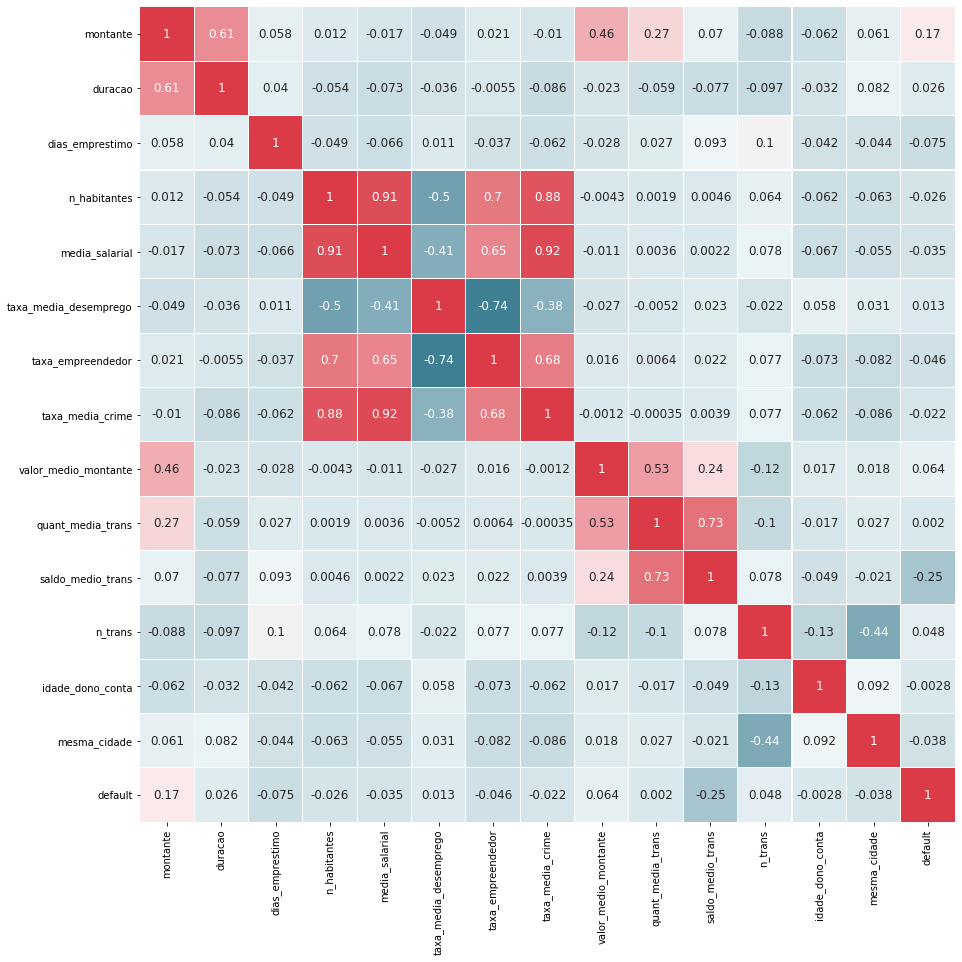

In [25]:
fig, ax = plt.subplots(figsize=(20, 15))
sns.heatmap(
        df_ml.corr(), 
        cmap = sns.diverging_palette(220, 10, as_cmap = True),
        square=True, 
        cbar=False,
        ax=ax,
        annot=True, 
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':12 })
plt.show()

<a name='transformation'></a>
## 5. Transformações

Transformações rápidas: as variáveis ​​numéricas são escaladas usando MinMaxScaler e as variáveis ​​categóricas são codificadas em um ponto.

In [36]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

In [37]:
# Defina as colunas numéricas e categóricas
num_cols = df_ml.columns[:-5]
cat_cols = df_ml.columns[-5:]

In [38]:
col_trans = ColumnTransformer([
    ('num', MinMaxScaler(), num_cols),
    ('cat', OneHotEncoder(drop='if_binary'), cat_cols)
])

In [39]:
print(col_trans)

ColumnTransformer(transformers=[('num', MinMaxScaler(),
                                 Index(['montante', 'duracao', 'pagamentos', 'dias_emprestimo', 'n_habitantes',
       'media_salarial', 'taxa_media_desemprego', 'taxa_empreendedor',
       'taxa_media_crime', 'valor_medio_montante', 'quant_media_trans',
       'saldo_medio_trans', 'n_trans', 'idade_dono_conta'],
      dtype='object')),
                                ('cat', OneHotEncoder(drop='if_binary'),
                                 Index(['frequencia', 'tipo_cartao', 'mesma_cidade', 'sexo_dono', 'default'], dtype='object'))])


In [40]:
df_transformed = col_trans.fit_transform(df_ml)
X = df_transformed[:, :-1]
y = df_transformed[:, -1]

<a name='modeling'></a>
## 6. Modelagem

Novamente, este é apenas um modelo de linha de base, usando RandomForestClassifier, que é um dos modelos mais populares e simples. As métricas de desempenho são escolhidas de acordo com a precisão, F1, ROC AUC. Além disso, as matrizes de confusão são calculadas.

In [57]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, plot_confusion_matrix, plot_roc_curve

In [58]:
# Divisão do dataframe em teste de treinamento

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y, random_state=10)


In [59]:
# desempenho do modelo inicial
clf = RandomForestClassifier(random_state=10)
print('Acc:', cross_val_score(clf, X_train, y_train, cv=StratifiedKFold(n_splits=5), scoring='accuracy').mean())
print('F1:', cross_val_score(clf, X_train, y_train, cv=StratifiedKFold(n_splits=5), scoring='f1').mean())
print('ROC AUC:', cross_val_score(clf, X_train, y_train, cv=StratifiedKFold(n_splits=5), scoring='roc_auc').mean())

Acc: 0.8947682752030579
F1: 0.10303030303030303
ROC AUC: 0.7393827160493827


### Refinando

Ajustado F1 Score com precisão 

In [60]:
params = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5]
}

In [61]:
clf = GridSearchCV(RandomForestClassifier(random_state=10), param_grid=params, 
                   cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=10), scoring='f1')
clf.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=10, shuffle=True),
             estimator=RandomForestClassifier(random_state=10),
             param_grid={'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 5],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [10, 50, 100, 200]},
             scoring='f1')

In [62]:
print(clf.best_params_)

{'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 10}


In [63]:
clf.best_score_

0.14242424242424243

### usando os melhores parâmetros

In [64]:
clf = RandomForestClassifier(n_estimators=10,
                             max_depth=None,
                             min_samples_split=5,
                             min_samples_leaf=1,
                             random_state=11)

In [65]:
clf.fit(X_train, y_train)

RandomForestClassifier(min_samples_split=5, n_estimators=10, random_state=11)

### Desempenho no conjunto de treinamento

In [66]:
y_train_pred = clf.predict(X_train)
y_train_proba = clf.predict_proba(X_train)

In [67]:
print('Train Acc:', accuracy_score(y_train, y_train_pred))
print('Train F1:', f1_score(y_train, y_train_pred))
print('Train ROC AUC:', roc_auc_score(y_train, y_train_proba[:, 1]))

Train Acc: 0.9758771929824561
Train F1: 0.8791208791208792
Train ROC AUC: 0.9994190268700072


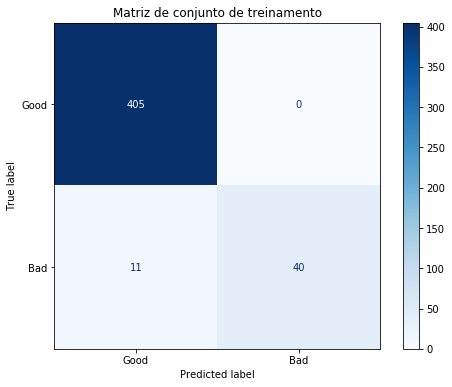

In [75]:
# Ajustando o modelo com os melhores parâmetros, podemos dar uma olhada no desempenho do modelo em todo o conjunto de trem 
# e no conjunto de teste:
fig, ax = plt.subplots(figsize=(8, 6))
plot_confusion_matrix(clf, X_train, y_train, display_labels=['Good', 'Bad'], 
                      cmap=plt.cm.Blues, ax=ax)
ax.set_title('Matriz de conjunto de treinamento')
plt.show()

### Desempenho no conjunto de teste

In [69]:
y_test_pred = clf.predict(X_test)
y_test_proba = clf.predict_proba(X_test)

In [70]:
print('test Acc:', accuracy_score(y_test, y_test_pred))
print('test F1:', f1_score(y_test, y_test_pred))
print('test ROC AUC:', roc_auc_score(y_test, y_test_proba[:, 1]))

test Acc: 0.8982300884955752
test F1: 0.25806451612903225
test ROC AUC: 0.7560199004975123


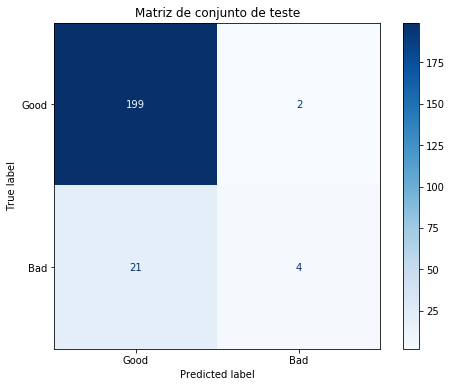

In [72]:
 
fig, ax = plt.subplots(figsize=(8, 6))
plot_confusion_matrix(clf, X_test, y_test, display_labels=['Good', 'Bad'], 
                      cmap=plt.cm.Blues, ax=ax)
ax.set_title('Matriz de conjunto de teste')
plt.show()

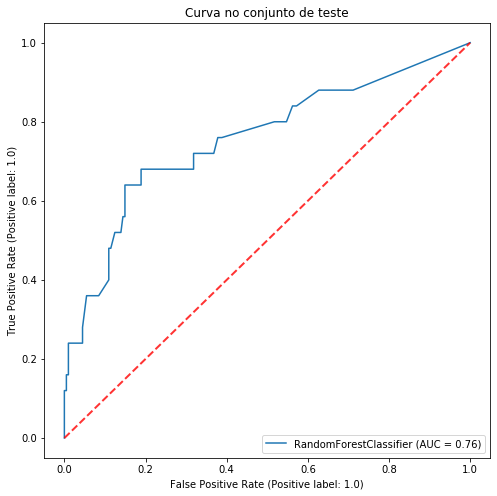

In [74]:
 
fig, ax = plt.subplots(figsize=(8, 8))
plot_roc_curve(clf, X_test, y_test, ax=ax)
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)
ax.set_title('Curva no conjunto de teste')
plt.show()

## 7. Importância do recurso

Com o modelo construído, agora podemos classificar os recursos com base em sua importância. Os 5 principais recursos com mais poderes de previsão são::
- Saldo médio de transação
- Valor médio da transação
- Montante do empréstimo
- Salário médio
- Dias entre a criação da conta e o pedido de empréstimo  

In [77]:
feature_names = num_cols.tolist() + col_trans.transformers_[1][1].get_feature_names().tolist()[:-1]
df_importance = pd.DataFrame({'característica': feature_names, 'importância': clf.feature_importances_})
df_importance.sort_values('importância', ascending=False)

,característica,importância
11,saldo_medio_trans,0.146062
2,pagamentos,0.091767
7,taxa_empreendedor,0.090008
5,media_salarial,0.084429
9,valor_medio_montante,0.082080
0,montante,0.078777
10,quant_media_trans,0.070066
3,dias_emprestimo,0.064267
12,n_trans,0.048833
13,idade_dono_conta,0.047277
